## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [16]:
import os
import numpy as np
import math
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import jit, njit, vectorize, cuda


In [17]:
from numba import njit
import numpy as np

@njit
def log_exp_vec(x):
    l=np.log(x)
    e=np.exp(x)
    return l,e

A=[2,5,10,3,8]
A=np.array(A)


print(log_exp_vec(A))

(array([0.69314718, 1.60943791, 2.30258509, 1.09861229, 2.07944154]), array([7.38905610e+00, 1.48413159e+02, 2.20264658e+04, 2.00855369e+01,
       2.98095799e+03]))


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [3]:
import numpy as np
from numba import jit

x=np.linspace(-3,3,100000)
x=np.array(x)

@jit(nopython=True)

def prob_fun(x):
    y=[]
    mean=1
    sigma=1
    for i in range(x.size):
        y.append( np.exp(-(x[i]-mean)**2/(2*sigma**2) )/np.sqrt(2*np.pi*sigma**2) ) 
    
    y=np.array(y)  
    
    return(y)

prob_fun(x)

array([0.00013383, 0.00013386, 0.00013389, ..., 0.05400393, 0.05399745,
       0.05399097])

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

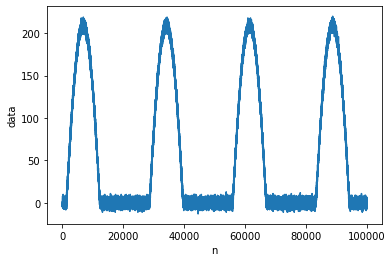

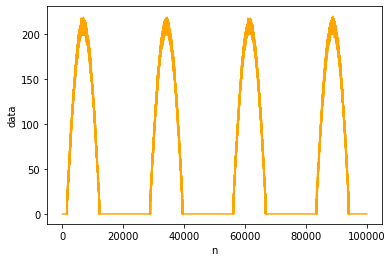

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

plt.plot(np.arange(n),data)
plt.xlabel("n")
plt.ylabel("data")
plt.show()

@jit(nopython=True,fastmath=True)

def zero_suppress(data):
    data_filtred=[]
    for i in range(n):
        if data[i]<15:
            data_filtred.append(0)
        else:
            data_filtred.append(data[i])
            
    data_filtred=np.array(data_filtred)   
    return(data_filtred)


plt.plot(np.arange(n),zero_suppress(data),color="orange" )
plt.xlabel("n")
plt.ylabel("data")
plt.show()
    

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
from numba import jit

X = np.random.rand(3,3)
Y = np.random.rand(3,3)

@jit(nopython=True,fastmath=True,parallel=True)
def kernel(x,y):
    
    alpha=1
    c=0
    
    return(np.tanh(alpha*x.T*y+c))

print("The Sigmoid kernel is : ",kernel(X,Y))

The Sigmoid kernel is :  [[0.55801533 0.51386373 0.00082519]
 [0.56296665 0.08118014 0.03661013]
 [0.10311511 0.01162219 0.5373356 ]]


# Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [7]:


from numba import cuda

# CUDA kernel
@cuda.jit
def cos_kernel_3D(io_array):
    row, col, l = cuda.grid(3)
    if row < io_array.shape[0] and col < io_array.shape[1] and l < io_array.shape[2]:
        io_array[row][col][l] *= math.cos(io_array[row][col][l]) # do the computation

x = np.random.normal(size=(256,256,256))


threadsperblock = (16, 16)
blockspergrid_x = int(math.ceil(x.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(x.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)


cos_kernel_3D[blockspergrid, threadsperblock](x)
print(x)

[[[-0.0859912   0.75684059 -0.27823633 ... -0.10622932 -0.56084954
   -0.87911043]
  [-0.2016076   1.38512022  0.77556404 ...  0.2071207   0.9053703
   -1.03572069]
  [-0.01624427  0.03455338 -0.38004421 ...  0.3791315   0.15142768
    1.23113437]
  ...
  [-0.06249819  0.08048413  0.99875073 ...  1.31876533  0.28244551
    1.16609207]
  [ 0.25217358 -1.125411   -0.80394581 ... -0.64827097  1.93383967
   -1.34175932]
  [ 1.27257276 -1.76306239  1.24878498 ... -1.53756736  0.17152616
   -0.88797199]]

 [[ 0.0799937   0.00415177 -0.8450913  ...  1.9508329  -2.22398817
   -1.10120398]
  [ 0.23788113 -0.19155355  0.54656136 ...  0.09953158 -0.08056545
   -0.57721469]
  [-0.50065969 -0.42282877  0.81524024 ...  0.94610799 -0.80068979
    1.46353477]
  ...
  [ 0.25711758 -0.04749321 -1.54540307 ...  0.65753781  0.22223925
    0.27461895]
  [ 0.04917228 -2.90044164 -0.84418207 ... -0.54440931  1.22503551
   -0.05810535]
  [-0.52642388 -1.42561543  0.73217123 ... -0.22289237 -0.21274235
    0.1

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [15]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp
r=300
# Initialize the data arrays
A = np.random.rand(r,r)
B = np.random.rand(r,r)

# Configure the blocks
threadsperblock = (r, r)
blockspergrid_x = 1
blockspergrid_y = 1
blockspergrid = (blockspergrid_x, blockspergrid_y)

C = np.zeros((r,r))
matmul[blockspergrid, threadsperblock](A, B, C)

np.all(np.matmul(A,B) == C)


False